In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')
 !cp /content/drive/MyDrive/dataset_images.zip /content/
 !unzip dataset_images.zip

In [ ]:
import os
import shutil
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df = pd.read_csv("dataset_columns.csv")
df = df[['Image Index', 'Finding Labels']].dropna()
df['Image Index'] = df['Image Index'].str.strip().str.lower()
df['Finding Labels'] = df['Finding Labels'].str.strip()
image_labels = dict(zip(df['Image Index'], df['Finding Labels']))
unique_conditions = sorted(set(label for entry in df['Finding Labels'] for label in entry.split('|')))
condition_to_index = {cond: idx for idx, cond in enumerate(unique_conditions)}
index_to_condition = {idx: cond for cond, idx in condition_to_index.items()}
num_conditions = len(unique_conditions)

def encode_multilabel(label_str):
    label_vector = [0] * num_conditions
    for condition in label_str.split('|'):
        if condition in condition_to_index:
            label_vector[condition_to_index[condition]] = 1
    return label_vector

image_dir = 'merged_images'

label_map = dict(zip(df['Image Index'], df['Finding Labels']))
all_images = [f for f in os.listdir(image_dir) if f.lower().endswith('.png')]


matched = [(fname, label_map[fname.lower()]) for fname in all_images if fname.lower() in label_map]
matched_images, matched_labels = zip(*matched) if matched else ([], [])

X_train, X_temporary, y_train, y_temporary = train_test_split(matched_images, matched_labels, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temporary, y_temporary, test_size=0.5, random_state=42)


output_dir = 'split_dataset'
os.makedirs(output_dir, exist_ok=True)
for subset in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, subset), exist_ok=True)

def process_dataset(images, labels, subset):
    subset_dir = os.path.join(output_dir, subset)
    label_file = os.path.join(output_dir, f'{subset}_labels.txt')

    for img in images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(subset_dir, img)
        shutil.copyfile(src, dst)

    with open(label_file, 'w') as f:
        for img, label in zip(images, labels):
            f.write(f"{img} {label}\n")

process_dataset(X_train, y_train, 'train')
process_dataset(X_validation, y_validation, 'val')
process_dataset(X_test, y_test, 'test')


print("\nDataset splitting complete!")
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_validation)} images")
print(f"Test: {len(X_test)} images")
print(f"Total matched: {len(matched_images)} images")
print(f"Total unmatched: {len(all_images) - len(matched_images)} images")


Using device: cuda

Dataset splitting complete!
Train: 42693 images
Validation: 9148 images
Test: 9149 images
Total matched: 60990 images
Total unmatched: 0 images


In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3,
                                   stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class MobileNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            *[DepthwiseSeparableConv(512, 512, stride=1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d(1),  
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct_imgs, total_imgs = 0.0, 0, 0
    all_predictions, all_targets = [], []

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicts = (torch.sigmoid(logits) > 0.5).float()
        correct_imgs += (predicts == labels).all(dim=1).sum().item()
        total_imgs   += labels.size(0)

        all_predictions.append(predicts.cpu())
        all_targets.append(labels.cpu())

    y_prediction = torch.cat(all_predictions).numpy()
    y_true = torch.cat(all_targets).numpy()

    return (
        running_loss / len(dataloader),
        100.0 * correct_imgs / total_imgs,
        precision_score(y_true, y_prediction, average='macro', zero_division=0),
        recall_score(y_true, y_prediction, average='macro', zero_division=0),
        f1_score(y_true, y_prediction, average='macro', zero_division=0)
    )

In [12]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct_imgs, total_imgs = 0.0, 0, 0
    all_predictions, all_targets, all_logits = [], [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct_imgs += (preds == labels).all(dim=1).sum().item()
            total_imgs += labels.size(0)

            all_predictions.append(preds.cpu())
            all_targets.append(labels.cpu())


    y_prediction = torch.cat(all_predictions).numpy()
    y_true = torch.cat(all_targets).numpy()
    return (
        running_loss / len(dataloader),
        100.0 * correct_imgs / total_imgs,
        precision_score(y_true, y_prediction, average='macro', zero_division=0),
        recall_score(y_true, y_prediction, average='macro', zero_division=0),
        f1_score(y_true, y_prediction, average='macro', zero_division=0)
    )

In [13]:
import tqdm
print(f"{device} for training and testing")
all_conditions = set()

for labels in image_labels.values():
    all_conditions.update(labels.split('|'))

all_conditions = sorted(list(all_conditions))
condition_to_index = {cond: idx for idx, cond in enumerate(all_conditions)}
index_to_condition = {idx: cond for cond, idx in condition_to_index.items()}
num_classes = len(all_conditions)

print("The number of classes", num_classes)
print("Sample class indices:", condition_to_index)

def encode_multilabel(label_str):
    label_vector = [0] * num_classes

    for cond in label_str.split('|'):
        if cond in condition_to_index:
            label_vector[condition_to_index[cond]] = 1

    return label_vector

y_train = [encode_multilabel(image_labels[img]) for img in X_train]
y_validation = [encode_multilabel(image_labels[img]) for img in X_validation]
y_test = [encode_multilabel(image_labels[img]) for img in X_test]

class LabeledImageDataset(Dataset):
    def __init__(self, image_filenames, labels, image_dir, transform = None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        label = torch.tensor(self.labels[idx], dtype = torch.float32)
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = LabeledImageDataset(X_train, y_train, 'split_dataset/train', transform)
validation_dataset = LabeledImageDataset(X_validation, y_validation, 'split_dataset/val', transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0)
validation_loader = DataLoader(validation_dataset, batch_size = 32, shuffle = False, num_workers = 0)
img, label = train_dataset[0]
model = MobileNet(num_classes = num_classes)
model = model.to(device)

with torch.no_grad():
    dummy = torch.randn(1, 1, 224, 224).to(device)
    out = model(dummy)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
num_epochs = 10
train_losses, validation_losses = [], []
train_accuracies, validation_accuracies = [], []
train_f1s, validation_f1s = [], []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_model(model, train_loader, optimizer, criterion, device)
    validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1 = evaluate_model(model, validation_loader, criterion, device)

    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    train_f1s.append(train_f1)
    validation_f1s.append(validation_f1)

    elapsed = time.time() - start_time
    eta = elapsed * (num_epochs - epoch - 1)

    print(f"\nEpoch {epoch + 1} of {num_epochs}  Time: {elapsed:.2f}s  ETA: {eta / 60:.1f} min")
    print(f"Train loss: {train_loss:.2f} | Accuracy: {train_accuracy:.2f}% | Precision: {train_precision:.2f} | Recall: {train_recall:.2f} | F1: {train_f1:.2f}")
    print(f"Validation loss: {validation_loss:.2f} | Accuracy: {validation_accuracy:.2f}% | Precision: {validation_precision:.2f} | Recall: {validation_recall:.2f} | F1: {validation_f1:.2f}")


cuda for training and testing
The number of classes 6
Sample class indices: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2, 'Mass': 3, 'No Finding': 4, 'Nodule': 5}

Epoch 1 of 10  Time: 254.11s  ETA: 38.1 min
Train loss: 0.41 | Accuracy: 30.91% | Precision: 0.28 | Recall: 0.12 | F1: 0.13
Validation loss: 0.40 | Accuracy: 29.85% | Precision: 0.37 | Recall: 0.14 | F1: 0.17

Epoch 2 of 10  Time: 223.73s  ETA: 29.8 min
Train loss: 0.39 | Accuracy: 34.92% | Precision: 0.39 | Recall: 0.15 | F1: 0.18
Validation loss: 0.39 | Accuracy: 34.47% | Precision: 0.37 | Recall: 0.17 | F1: 0.20

Epoch 3 of 10  Time: 221.87s  ETA: 25.9 min
Train loss: 0.36 | Accuracy: 38.83% | Precision: 0.58 | Recall: 0.21 | F1: 0.25
Validation loss: 0.41 | Accuracy: 32.17% | Precision: 0.34 | Recall: 0.17 | F1: 0.21

Epoch 4 of 10  Time: 258.98s  ETA: 25.9 min
Train loss: 0.30 | Accuracy: 49.10% | Precision: 0.66 | Recall: 0.33 | F1: 0.39
Validation loss: 0.45 | Accuracy: 28.14% | Precision: 0.34 | Recall: 0.22 |

In [14]:
torch.save(model.state_dict(), "mobilenet_model_4thmay_12_57.pth")

In [ ]:
import pandas as pd
from pathlib import Path
from datetime import datetime


out_dir = Path("runs") / datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir.mkdir(parents=True, exist_ok=True)


epochs = range(1, len(train_losses) + 1)
df = pd.DataFrame({
    "epoch":          epochs,
    "train_loss":     train_losses,
    "val_loss":       validation_losses,
    "train_acc":      train_accuracies,
    "val_acc":        validation_accuracies,
    "train_f1":       train_f1s,
    "val_f1":         validation_f1s,
})

combined_csv = out_dir / "training_metrics.csv"
df.to_csv(combined_csv, index=False)
print(f"✓ Saved combined metrics → {combined_csv}")

metrics = {
    "train_losses":     train_losses,
    "val_losses":       validation_losses,
    "train_accuracies": train_accuracies,
    "val_accuracies":   validation_accuracies,
    "train_f1s":        train_f1s,
    "val_f1s":          validation_f1s,
}
for name, series in metrics.items():
    pd.Series(series, name=name).to_csv(out_dir / f"{name}.csv",
                                        index_label="epoch")
print(f"✓ Saved individual metric CSVs → {out_dir}")


✓ Saved combined metrics → runs/20250504_172404/training_metrics.csv
✓ Saved individual metric CSVs → runs/20250504_172404


In [ ]:
test_dataset = LabeledImageDataset(X_test, y_test, 'split_dataset/test', transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate_model(model, test_loader, criterion, device)

print("\n Final Test Set Evaluation:")
print(f"   Test  - Loss: {test_loss:.4f} | Acc: {test_acc:.2f}% | Prec: {test_prec:.2f} | Rec: {test_rec:.2f} | F1: {test_f1:.2f}")



 Final Test Set Evaluation:
   Test  — Loss: 0.9448 | Acc: 34.73% | Prec: 0.30 | Rec: 0.22 | F1: 0.25


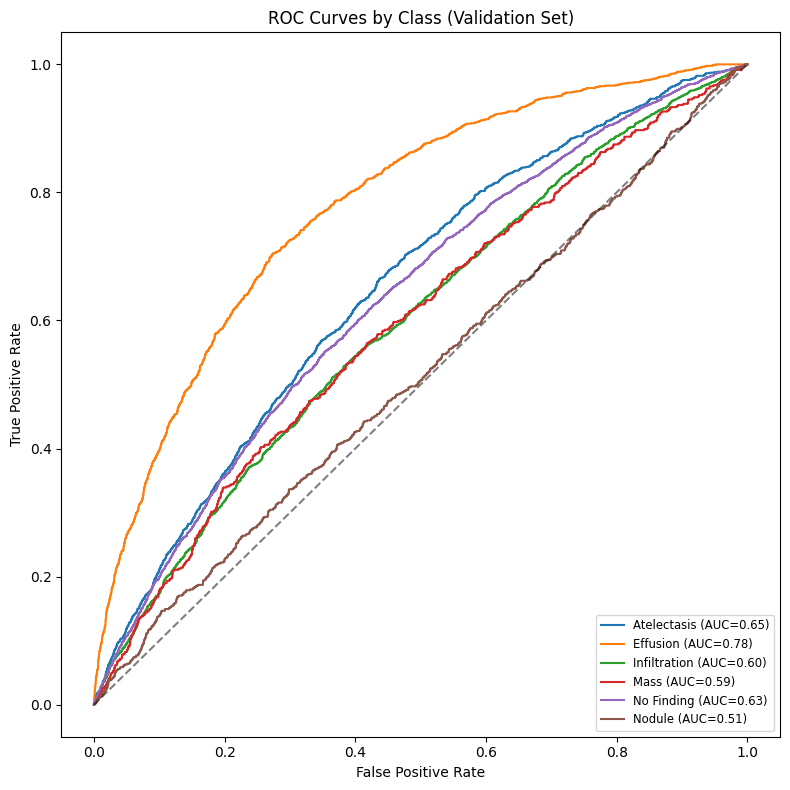

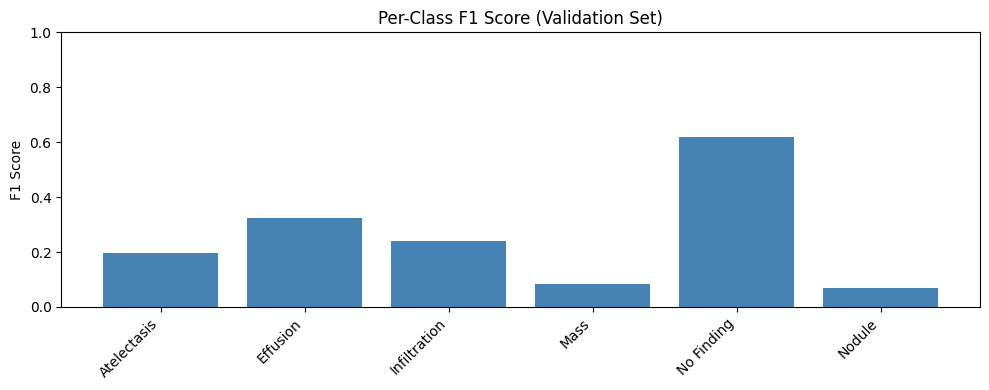

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score


epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train BCE')
plt.plot(epochs, validation_losses, label='Val BCE')
plt.xlabel('Epoch'); plt.ylabel('Binary-cross-entropy')
plt.title('BCE Loss per Epoch')
plt.legend(); plt.grid(True, ls='--', alpha=.4)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1s, label='Train F1')
plt.plot(epochs, validation_f1s, label='Val F1')
plt.xlabel('Epoch'); plt.ylabel('Macro-F1'); plt.ylim(0, 1)
plt.title('Macro-F1 per Epoch')
plt.legend(); plt.grid(True, ls='--', alpha=.4)

plt.tight_layout()
plt.show()

model.eval()
probs_list, labels_list = [], []

with torch.no_grad():
    for imgs, lbls in validation_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu()
        probs_list.append(probs)
        labels_list.append(lbls)

probs_all = torch.cat(probs_list).numpy()
labels_all = torch.cat(labels_list).numpy()

plt.figure(figsize=(8, 8))
f1_per_class = {}

for i, cond in index_to_condition.items():
    fpr, tpr, _ = roc_curve(labels_all[:, i], probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cond} (AUC={roc_auc:.2f})')
    preds_bin = (probs_all[:, i] >= 0.5).astype(int)
    f1 = f1_score(labels_all[:, i], preds_bin, zero_division=0)
    f1_per_class[cond] = f1

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class (Validation Set)')
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(f1_per_class.keys(), f1_per_class.values(), color='steelblue')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Score (Validation Set)')
plt.tight_layout()
plt.show()
